In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.transforms import Affine2D
import numpy as np
import math
from matplotlib.patheffects import RendererBase
import matplotlib.patheffects as PathEffects
import seaborn as sns

In [325]:
def Rotate(v, theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]]) @ np.array(v).T

def DrawPolygon(x, y, radius, n_edge, facecolor, ax):
    """
    Draw a shape with n_edges centered at x,y, with raidus (center to corner)
    n_edge <= 0 means circle
    """
    if (n_edge > 0):
        points = []
        for j in range(n_edge):
            cx = 0
            cy = radius
            cx, cy = Rotate([cx, cy], (j-0.5) * 2*math.pi/n_edge)
            points.append([cx+x, cy+y])
        ax.add_patch(patches.Polygon(points, facecolor=color, edgecolor="white"))
    else:
        ax.add_patch(patches.Circle([x,y], radius=radius, facecolor=facecolor,
                                   edgecolor="white"))
    return ax

def GetLapGap(radius, n_edge):
    """
    The gap between two laps for the same-cluster plotting
    """
    return max([11 / 5 * radius / math.cos(math.pi / n_edge),#  extra 20% in the radius for buffer
                      6 / 5 * radius / math.sin(math.pi / n_edge)] # gap should be large enough so dots in the same lap does not overlap
              )

def EstimateClusterRectangularRegion(center_x, center_y, data, n_edge, radius):
    """
    Estimate the rectangular region 
    
    Return:
    -----
    (x_min, y_min), (x_max, y_max)
    """
    count = len(data)
    lap_gap = GetLapGap(raidus, n_edge)
    n_lap = math.ceil( math.log(count * (n_edge - 1) + 1, n) )
    return (center_x - lap_gap * n_lap - radius, \
            center_y - lap_gap * n_lap - radius), \
         (center_x +lap_gap * n_lap + radius, \
            center_y + lap_gap * n_lap + radius)

def EstimateClusterCircularRegion():
    """
    Esimate the circular region
    
    Return:
    -----
    (center_x, center_y), radius
    """
    count = len(data)
    lap_gap = GetLapGap(raidus, n_edge)
    n_lap = math.ceil( math.log(count * (n_edge - 1) + 1, n) )
    return (center_x, center_y), n_lap * lap_gap + radius

# Draw one cluster
def DrawCluster(center_x, center_y, data, hue, hue_map, facecolor, n_edge, radius, layout, ax):
    """
    Draw the plot for one cluster represent by data
    
    Return:
    -----
    axes object
    range of x
    range of y
    """
    
    count = len(data)
    x = []
    y = []
    
    colors = []
    if (hue != None):
        hue_counts = []
        for h, cnt in data[hue].value_counts().items():
            c = facecolor
            if (h in hue_map):
                c = hue_map[h]
            for i in range(cnt):
                colors.append(c)
    else:
        colors = [facecolor for i in range(count)]
        
    if (layout == "lap"):
        lap = 0
        
        #center difference between two laps
        lap_gap = GetLapGap(radius, n_edge)
               
        i = 0 
        while (i < count):
            tmpx = 0
            tmpy = lap * lap_gap 
            if (i == 0):
                tmpx, tmpy = Rotate([tmpx, tmpy], i * 2*math.pi/n_edge)
                x.append(tmpx + center_x)
                y.append(tmpy + center_y)
                i += 1
            else:
                k = 0
                for j in range(i, min(i+lap*n_edge, count), lap):
                    tmpx1, tmpy1 = Rotate([tmpx, tmpy], k * 2*math.pi/n_edge)
                    tmpx2, tmpy2 = Rotate([tmpx, tmpy], (k+1) * 2*math.pi/n_edge)
                    for l in range(j, min(j + lap, count)):
                        coef = (j + lap - l) / lap
                        x.append(coef*tmpx1 + (1-coef)*tmpx2 + center_x)
                        y.append(coef*tmpy1 + (1-coef)*tmpy2 + center_y)
                    k += 1
                i += lap * n_edge
            lap += 1
                
    elif (layout == "layer"):
        return ax
    elif (layout == "spiral"):
        return ax
    #print(x, y)
    for i, (xi, yi) in enumerate(zip(x, y)):
        DrawPolygon(xi, yi, radius, 0, colors[i], ax)
        
    min_x = min(x)
    max_x = max(x)
    min_y = min(y)
    max_y = max(y)
    
    return ax, (min_x, max_x), (min_y, max_y)

def HoneycombPlot(data, group, hue = None, facecolor = 'blue', 
                  layout="lap", n_edge=6, radius=1, palette=None, ax=None):
        """
        Draw the honeycomb plot 
        
        Args:
        -----
        data: panda dataframe holding the row data
        group: the column name in data that 
        hue: color of the dot based on the column in the dataframe. Use default color if it is not specified in this dictionary
        facecolor: color of the dot if hue is not specified.
        n_edge: number of edge for each cluster's shape, default 6 is a like heagonal shape
        radius: dot size
        layout: how to draw the dot within one cluster. 
                "spiral": a shape of spiral. 
                "lap": a dot in the center, and other dots around it as laps.
                "layer": dots a placed layer by layer 
        ax: axes objective
        
        Return:
        -----
        axes object
        """
        
        ax = ax or plt.gca()
        
        groupby = data.groupby(group)
        cluster_num = len(groupby)
        
        hue_map = {}
        if (hue != None):
            hlist = list(data[hue].unique())
            mypalette = sns.color_palette("bright", len(hlist))
            for i, h in enumerate(hlist):
                hue_map[h] = mypalette[i]
                
        i = 0
        #if (hue != None):
        #    hue_categories = 
        available_space = {} # a queue of available point
        for g, subdf in sorted(data.groupby("CDR3"), key=lambda item: len(item[1]), reverse=True):
            ax, _, _ = DrawCluster(i, 0, subdf, hue, hue_map, facecolor, n_edge, radius, layout, ax)
            i += 1
        return ax
        

In [16]:
df = pd.DataFrame({"CDR3":["ABC", "ABC", "ABC", "ABC",
                          "ABC", "ABC", "ABC", "ABC",
                          "ABC", "DEF", "DEF", "GHI"],
                  "Condition":["HD", "HD", "HD", "HD",
                              "D", "D", "HD", "D",
                              "HD", "HD", "D", "D"]})

[(-20.0, 20.0), (-20.0, 20.0)]

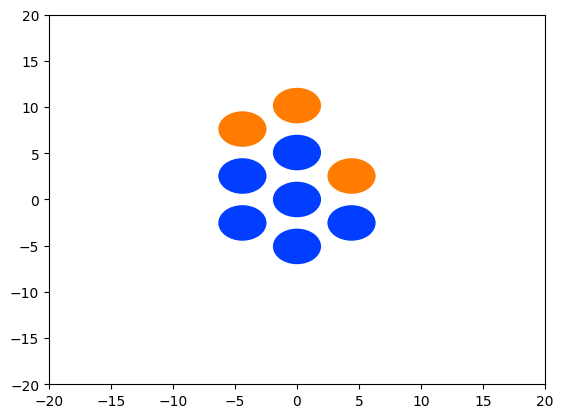

In [322]:
ax=HoneycombPlot(df[df["CDR3"]=="ABC"], "CDR3", hue="Condition", n_edge=6,radius=2)
ax.set(xlim=(-20, 20), ylim=(-20,20))

In [231]:
df[df["CDR3"]=="ABC"]

,CDR3,Condition
0,ABC,HD
1,ABC,HD
2,ABC,HD
3,ABC,HD
4,ABC,D
5,ABC,D
6,ABC,HD
7,ABC,D
8,ABC,HD


In [170]:
for x, subdf in sorted(df.groupby("CDR3"), key=lambda item: len(item[1]), reverse=True):
    print(x)
    print(subdf)

ABC
  CDR3 Condition
0  ABC        HD
1  ABC        HD
2  ABC        HD
3  ABC        HD
4  ABC         D
5  ABC         D
6  ABC        HD
7  ABC         D
8  ABC        HD
DEF
   CDR3 Condition
9   DEF        HD
10  DEF         D
GHI
   CDR3 Condition
11  GHI         D
